In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prudential-life-insurance-assessment/train.csv.zip
/kaggle/input/prudential-life-insurance-assessment/sample_submission.csv.zip
/kaggle/input/prudential-life-insurance-assessment/test.csv.zip


In [2]:
import pandas as pd
data=pd.read_csv('../input/prudential-life-insurance-assessment/train.csv.zip')
scoring_data=pd.read_csv('../input/prudential-life-insurance-assessment/test.csv.zip')

****check for nan in data

In [3]:
data.isna().values.any()

True

**We start by analysing number of nulls **

In [4]:
print("shape of input data set is {}".format(data.shape))
print("total number of columns with all values NaN are {}".format(data.isna().all().values.sum()))
print("total number of columns with atleast one NaN are {}".format(data.isna().any().values.sum()))

shape of input data set is (59381, 128)
total number of columns with all values NaN are 0
total number of columns with atleast one NaN are 13


**We see that each row has atleast one NaN but each time it belongs to a different column. So we cant use data.dropna() - that would delete all the rows. Let's find column-wise sum of all NaNs.**

In [5]:
cols_null=data.columns[data.isna().any()]
data[cols_null].isna().sum()

Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

**We need to decide on the number of NaN values that are accpeted in a feature that is used for training the data set** Lets choose 6000 to be the number. We need to remove all the columns with NaN values more than 6k to be removed from dataset -data.(we could also have used missing data as a feature by tagging it as zero)

In [6]:
cols_drop=data[cols_null].isna().sum()>6000
cols_not_drop=data[cols_null].isna().sum()<6000

#creating object names of columns from boolean cols_drop
drop_col_obj=cols_drop.index[cols_drop]
dataset=data.drop(drop_col_obj,axis=1)

#we also need to replace the NaN of 'Employment_info_1' - lets replace it with the mean value of the column
replace_col=cols_not_drop.index[cols_not_drop]
dataset[replace_col]=dataset[replace_col].replace(np.nan,dataset[replace_col].mean())

#check if we have missed any nulls
dataset.isna().any().sum()

0

**Let's explore the training dataset now**. 
Here is a list of feature selection techniques that we can use-
1. Remove features that have very low variance
2. Remove of one of the 2 features if there is a high correlation between them.
3. Remove features with very low correlation with the target.
4. Add loop to go through different features and select those which provide the best results.
5. LASSO- Least Absolute Shrinkage and Selection Order.
6. Tree based - forest trees to evalute importance of features/PCA/ Cluster analysis

**First check if all features are of type int or float**

In [7]:
#to find different types of datatypes used in dataset
print(dataset.dtypes.unique())

#to find which columns have datatype not as int64 or float64
obj_col_name=dataset.select_dtypes(include=['object']).columns
print(obj_col_name)

obj_data=dataset[obj_col_name]
 
col_one_hot=obj_data.Product_Info_2.unique()
#to find number of unique values in the datatype which has type 'O'
print(" the number of unique items are",col_one_hot)


[dtype('int64') dtype('O') dtype('float64')]
Index(['Product_Info_2'], dtype='object')
 the number of unique items are ['D3' 'A1' 'E1' 'D4' 'D2' 'A8' 'A2' 'D1' 'A7' 'A6' 'A3' 'A5' 'C4' 'C1'
 'B2' 'C3' 'C2' 'A4' 'B1']


***We use one hot encoding to convert "Product_Info_2" into differenet lablels*** we are doing this before split in this case. This is debatable as it could lead to data leakage in many cases

In [8]:
one_hot_enc=pd.get_dummies(obj_data.Product_Info_2)

#drop the feature with type object
dataset=dataset.drop(['Product_Info_2'],axis=1)

#we can also drop the id column as it is only the serial number
dataset=dataset.drop(['Id'],axis=1)

#now we append one_hot_enc to out dataset
dataset=pd.concat([dataset.reset_index(),one_hot_enc.reset_index()],axis=1).drop(['index'],axis=1)


**Test train split**

In [9]:
#first split dataset into X and y
X= dataset.drop(['Response'],axis=1)

y= dataset['Response']

#now split X,y into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=20)

In [10]:
#check for Nan in X here
X.isna().any().sum()

0

In [11]:
#let's check number of unique values of 'Response'
print('number of unique values of response are {}'.format(y_train.nunique()))
print('the unique values of response are {}'.format(y_train.unique()))

number of unique values of response are 8
the unique values of response are [2 8 4 6 7 1 5 3]


**We should check variance of each feature before applying fit transform and training the dataset**

In [12]:
print(X_train.var().sort_values(ascending=False))
print("\n\nNumber of unique items in Medical_History_2 are ",X_train['Medical_History_2'].nunique())

Medical_History_2      31804.885811
Product_Info_3            25.886860
Employment_Info_2         17.829969
InsuredInfo_3              7.143939
Insurance_History_3        0.980244
                           ...     
C4                         0.003806
Medical_History_35         0.003742
A4                         0.003507
C2                         0.002682
B1                         0.000979
Length: 132, dtype: float64


Number of unique items in Medical_History_2 are  522


In [13]:
#check for Nan here in X_train
X_train.isna().any().sum()

0

In [14]:
#selecting features which have variance greater than 0.8
fea_sort=X_train.var().sort_values(ascending=False)

#defining an array which would store features with high variance
fea_hig_var=[]

#minimum required threshold variance of a feature 
minimum_var=0.8
i=0
while fea_sort[i]>minimum_var:
    fea_hig_var.append(fea_sort.index[i])
    i=i+1
        
print('\nTotal {} features selected by setting minimum required varince to {}, these are {}'.format(i,minimum_var,fea_hig_var) )


Total 8 features selected by setting minimum required varince to 0.8, these are ['Medical_History_2', 'Product_Info_3', 'Employment_Info_2', 'InsuredInfo_3', 'Insurance_History_3', 'Insurance_History_7', 'Insurance_History_4', 'Medical_History_41']


In [15]:
#we select the high varince features for train and test
X_train_high=X_train[fea_hig_var]
X_test_high=X_test[fea_hig_var]

***MI index for feature selection***

In [16]:
from sklearn.feature_selection import mutual_info_classif

# Define a custom function that calculates Mutual Information (MI) scores for a given dataset.
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Define a custom function that plots MI scores in descending order (i.e. most important to least important).
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

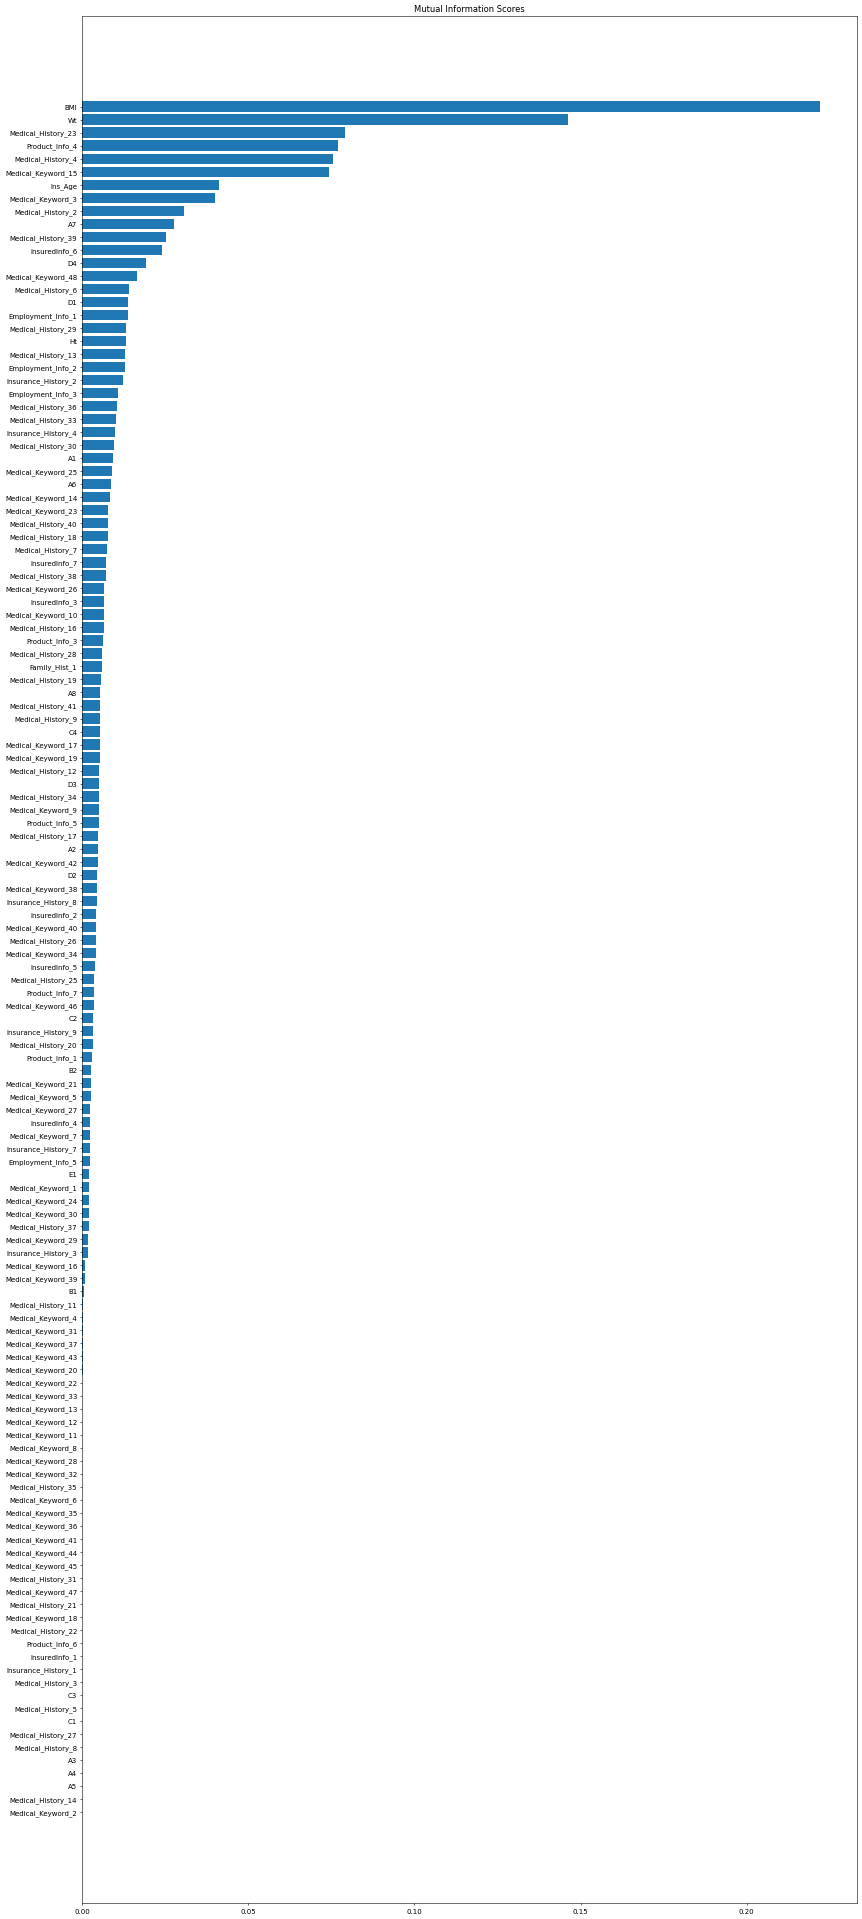

In [17]:
# Calculate MI scores on the validation dataset.
import matplotlib.pyplot as plt
mi_scores_X_valid = make_mi_scores(X_train, y_train)

# Plot the MI scores obtained from the validation dataset.
plt.figure(dpi=50, figsize=(20,50))
plot_mi_scores(mi_scores_X_valid)

***Lets select features with MI index greater than 0.01 ***

In [18]:
mi_compare=mi_scores_X_valid.gt(0.01)
mi_features=mi_scores_X_valid[mi_compare].index
X_train_mi=X_train[mi_features]
X_test_mi=X_test[mi_features]

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth=20, criterion = 'entropy', 
                            min_samples_leaf= 3,min_samples_split= 3)
rf=rf.fit(X_train_mi,y_train)
y_pred=rf.predict(X_test_mi)
print(len(np.unique(y_pred)))

8


In [20]:
y_predict_train_rf = rf.predict(X_train_mi)
y_predict_test_rf = rf.predict(X_test_mi)

train_accuracy_score_rf = accuracy_score(y_train, y_predict_train_rf)
test_accuracy_score_rf = accuracy_score(y_test, y_predict_test_rf)

print(train_accuracy_score_rf)
print(test_accuracy_score_rf)

0.753952494658791
0.518269034496836


***The test accuracy is not going above 52 on varying threshold mi index, or rf parameter***